In [1]:
from exploitation_strategy import IceFishingExploitationStrategy
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from scipy.special import expit

In [50]:
def simulate_spot_leaving(is_spot_successful=0, catch_every=6):
    strategy = IceFishingExploitationStrategy(
                    baseline_weight=-3.0,
                    fish_catch_weight=-1.7,
                    time_weight=0.13,
                    social_feature_weight=0,
                    step_minutes=1/6
                )
    t_total = 0
    t_since_last_catch = 0
    stay = True
    
    while stay:
        if not strategy.stay_on_patch(time_since_last_catch=t_since_last_catch,
                                      is_spot_successful=is_spot_successful):
            stay = False
        
        t_total += 1
        t_since_last_catch += 1

        if is_spot_successful and t_since_last_catch == catch_every:
            t_since_last_catch = 0

            
    return t_total

In [51]:
catch_every = 9  # 3/6 of a minute

time_unsuccessful_spots = [simulate_spot_leaving(catch_every=catch_every)*10 for _ in range(10000)]
# time_successful_spots = time_unsuccessful_spots
time_successful_spots = [simulate_spot_leaving(is_spot_successful=1, catch_every=catch_every)*10 for _ in range(10000)]

In [52]:
df = pd.DataFrame({
    "Angling Time spots (s)": time_unsuccessful_spots+time_successful_spots,
    "Is spot successful": ['No' for _ in range(10_000)] + ['Yes' for _ in range(10_000)]
})

In [53]:
df.groupby("Is spot successful").describe()

Angling Time spots (s)           ...               
                                    count     mean  ...    75%     max
Is spot successful                                  ...               
No                                10000.0   93.012  ...  130.0   290.0
Yes                               10000.0  636.848  ...  882.5  5690.0

[2 rows x 8 columns]

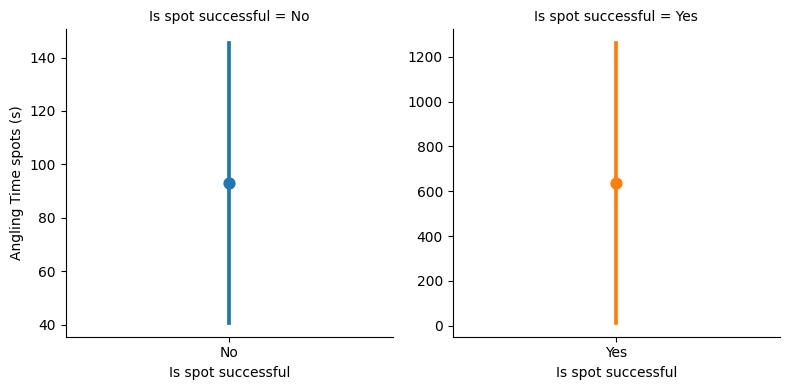

In [54]:
%matplotlib inline  
sns.catplot(
    data=df,
    #kind="boxen",
    estimator="mean",  # "median",
    kind="point",
    errorbar="sd",
    y="Angling Time spots (s)",
    x="Is spot successful",
    hue="Is spot successful",
    height=4,
    col="Is spot successful",
    sharey=False,
    sharex=False
)



plt.show()

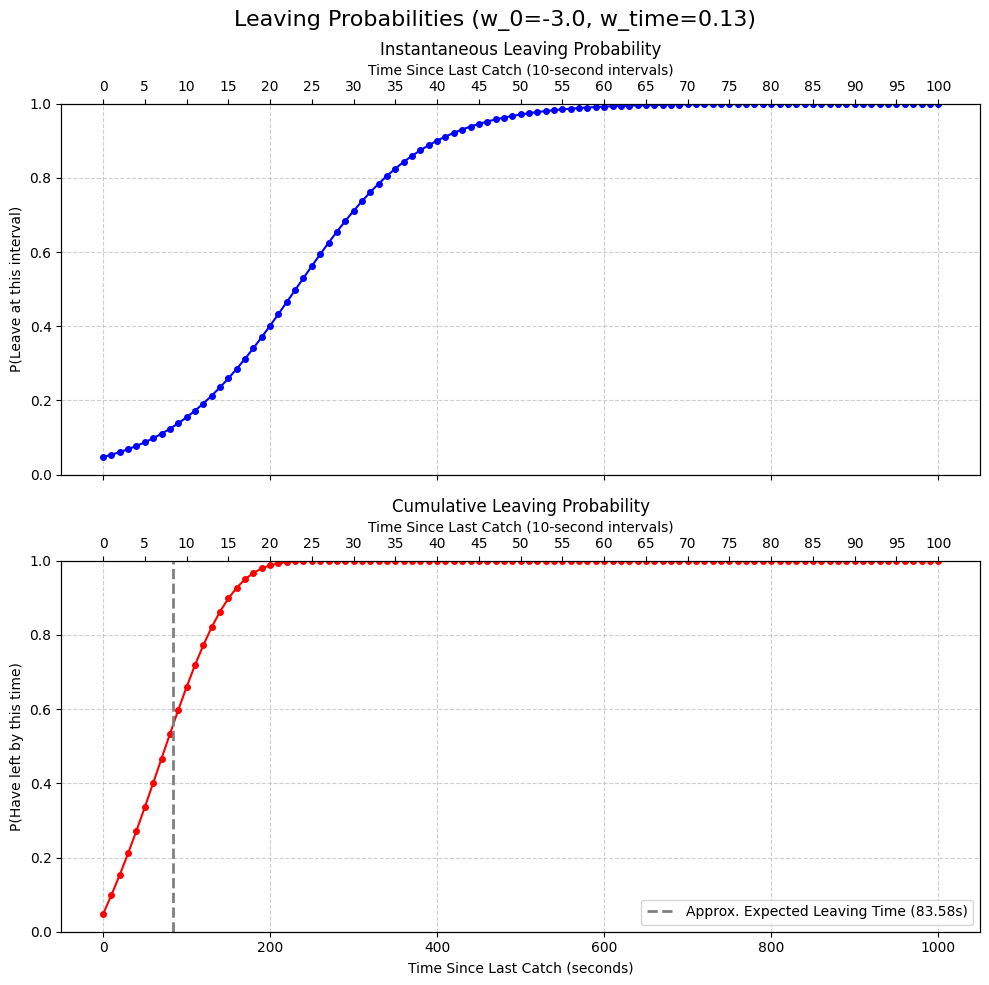

In [60]:
%matplotlib inline 
# --- Parameters ---
# You can change these weights to see different curves
w_0 = -3.0  # Intercept (baseline log-odds of leaving)
w_time = 0.13 # Time coefficient (how much log-odds increase per 10s interval)

# --- Time Intervals ---
# Create time intervals, e.g., from 0 to 30 (representing 0 to 300 seconds)
# time_intervals is array [0, 1, 2, ..., 30]
max_intervals = 100
time_intervals = np.arange(max_intervals + 1)
time_in_seconds = time_intervals * 10

# --- 1. Calculate Instantaneous Leaving Probability ---

# Calculate the logit
# p_leave_logit = w_0 + w_time * time_since_last_catch
p_leave_logit = w_0 + w_time * time_intervals

# Calculate the instantaneous probability using the expit (inverse logit) function
# p_leave = 1 / (1 + exp(-p_leave_logit))
p_leave_instantaneous = expit(p_leave_logit)

# --- 2. Calculate Cumulative Leaving Probability ---

# The probability of *staying* at any given interval t is (1 - p_leave(t))
p_stay_instantaneous = 1 - p_leave_instantaneous

# The cumulative probability of *having stayed* up to interval t
# is the product of all individual staying probabilities up to that point.
# P_stay(t) = p_stay(0) * p_stay(1) * ... * p_stay(t)
p_stay_cumulative = np.cumprod(p_stay_instantaneous)

# The cumulative probability of *having left* by interval t
# is simply 1 minus the cumulative probability of having stayed.
p_leave_cumulative = 1 - p_stay_cumulative

# --- 3. Calculate Expected Leaving Time ---

# The expected value (average time to leave) is the sum of the
# cumulative *staying* probability (survival function).
# E[T] = sum(P(T > t)) for t = 0 to infinity
expected_value_intervals = np.sum(p_stay_cumulative)


# P(leave exactly at t) = P(leave by t) - P(leave by t-1)
# np.diff finds this difference. We prepend 0 for the first interval.
p_leave_pmf = np.diff(p_leave_cumulative, prepend=0)

# Now, apply the E[T] definition: sum(time * P(T=t))
expected_value_intervals_pmf = np.sum(time_intervals * p_leave_pmf)

expected_value_seconds = expected_value_intervals_pmf * 10


# Note: This is an approximation because we only summed up to max_intervals.
# It's a good approximation if p_stay_cumulative is near 0 at the end.
# print(f"\n--- Analysis (w_0={w_0}, w_time={w_time}) ---")
# print(f"Probability of staying past {max_intervals * 10}s: {p_stay_cumulative[-1]:.4f}")
# print(f"Approx. Expected Leaving Time: {expected_value_intervals:.2f} intervals ({expected_value_seconds:.2f} seconds)\n")

# --- 4. Plot the Results ---

# Set up the figure and axes
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
fig.suptitle(f'Leaving Probabilities (w_0={w_0}, w_time={w_time})', fontsize=16)

# --- Plot 1: Instantaneous Probability ---
ax1.plot(time_in_seconds, p_leave_instantaneous, 'b-o', markersize=4)
ax1.set_title('Instantaneous Leaving Probability')
ax1.set_ylabel('P(Leave at this interval)')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.set_ylim(0, 1)

ax2_top = ax1.twiny()
ax2_top.set_xlabel('Time Since Last Catch (10-second intervals)')
ax2_top.set_xticks(time_in_seconds[::5])
ax2_top.set_xticklabels(time_intervals[::5])
ax2_top.set_xlim(ax2.get_xlim())

# --- Plot 2: Cumulative Probability ---
ax2.plot(time_in_seconds, p_leave_cumulative, 'r-o', markersize=4)
ax2.set_title('Cumulative Leaving Probability')
ax2.set_ylabel('P(Have left by this time)')
ax2.set_xlabel('Time Since Last Catch (seconds)')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.set_ylim(0, 1)

# Add the expected value line
ax2.axvline(x=expected_value_seconds, color='gray', linestyle='--', linewidth=2,
            label=f'Approx. Expected Leaving Time ({expected_value_seconds:.2f}s)')
ax2.legend(loc='lower right')


# Add a secondary x-axis to show the interval number
ax2_top = ax2.twiny()
ax2_top.set_xlabel('Time Since Last Catch (10-second intervals)')
ax2_top.set_xticks(time_in_seconds[::5])
ax2_top.set_xticklabels(time_intervals[::5])
ax2_top.set_xlim(ax2.get_xlim())

# Show the plot
plt.tight_layout()
plt.show()
